In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data
import datetime
from datetime import time
from pandas.tseries.frequencies import to_offset

In [2]:
start = datetime.datetime(2000, 1, 1)
end = datetime.date.today()

# BA boeing company, data from Yahoo finanse
stock_d = data.DataReader('BA', 'yahoo', start, end)
stock_d.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,41.6875,39.8125,41.4375,40.1875,2638200.0,25.940285
2000-01-04,41.1250,39.7500,40.1875,40.1250,3592100.0,25.899939
2000-01-05,43.3125,41.3750,41.3750,42.6250,7631700.0,27.513641
2000-01-06,43.4375,41.1250,42.6250,43.0625,4922200.0,27.796041
2000-01-07,44.8750,43.6875,43.6875,44.3125,6008300.0,28.602900


In [3]:
def week_open(array_like):
    return array_like[0]

def week_close(array_like):
    return array_like[-1]

logic = {'Open': week_open, 
                         'High': 'max',
                         'Low': 'min',
                         'Close': week_close,
                         'Volume': 'sum'}

stock_w = stock_d.resample('W').apply(logic) # Converting daily data to weekly
stock_w.index -= to_offset('6D')

stock_w = stock_w[['Open', 'High', 'Low', 'Close', 'Volume']]

In [4]:
print(stock_d.head(10))
stock_w.head()

               High      Low     Open    Close     Volume  Adj Close
Date                                                                
2000-01-03  41.6875  39.8125  41.4375  40.1875  2638200.0  25.940285
2000-01-04  41.1250  39.7500  40.1875  40.1250  3592100.0  25.899939
2000-01-05  43.3125  41.3750  41.3750  42.6250  7631700.0  27.513641
2000-01-06  43.4375  41.1250  42.6250  43.0625  4922200.0  27.796041
2000-01-07  44.8750  43.6875  43.6875  44.3125  6008300.0  28.602900
2000-01-10  44.5000  43.5000  44.3125  43.6875  2403500.0  28.199459
2000-01-11  43.9375  42.7500  43.6875  42.8750  2450000.0  27.675013
2000-01-12  44.1875  42.5000  42.8750  43.0625  2327800.0  27.796041
2000-01-13  43.3750  42.0000  43.0625  42.3750  3035100.0  27.352289
2000-01-14  44.2500  42.9375  42.9375  44.0000  3834900.0  28.401182


,Open,High,Low,Close,Volume
Date,,,,,
2000-01-03,41.4375,44.8750,39.7500,44.3125,24792500.0
2000-01-10,44.3125,44.5000,42.0000,44.0000,14051300.0
2000-01-17,44.0000,48.1250,43.1250,45.6875,30657000.0
2000-01-24,45.6875,46.8750,43.6250,44.6250,17080700.0
2000-01-31,44.5625,45.1875,42.5625,44.0000,14199400.0


In [5]:
stock_w.shape

(1172, 5)

#### Building the LSTM model

In [6]:
data_training = pd.DataFrame(stock_w['Close'][0:int(len(stock_w)*0.70)])
data_testing = pd.DataFrame(stock_w['Close'][int(len(stock_w)*0.70):int(len(stock_w))])

print(data_training.shape)
print(data_testing.shape)

(820, 1)
(352, 1)


In [7]:
data_training.head()

,Close
Date,
2000-01-03,44.3125
2000-01-10,44.0000
2000-01-17,45.6875
2000-01-24,44.6250
2000-01-31,44.0000


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [9]:
data_training_array = scaler.fit_transform(data_training)
data_training_array.shape

(820, 1)

In [10]:
x_train = []
y_train = []

for i in range(100,data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)   

In [11]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.metrics import mean_absolute_error

In [12]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [14]:
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 50)

Epoch 1/50
23/23 [==============================] - 8s 182ms/step - loss: 0.0632
Epoch 2/50
23/23 [==============================] - 4s 179ms/step - loss: 0.0172
Epoch 3/50
23/23 [==============================] - 4s 176ms/step - loss: 0.0133
Epoch 4/50
23/23 [==============================] - 4s 178ms/step - loss: 0.0135
Epoch 5/50
23/23 [==============================] - 4s 178ms/step - loss: 0.0111
Epoch 6/50
23/23 [==============================] - 4s 174ms/step - loss: 0.0099
Epoch 7/50
23/23 [==============================] - 4s 171ms/step - loss: 0.0091
Epoch 8/50
23/23 [==============================] - 4s 188ms/step - loss: 0.0080
Epoch 9/50
23/23 [==============================] - 4s 177ms/step - loss: 0.0083
Epoch 10/50
23/23 [==============================] - 4s 176ms/step - loss: 0.0072
Epoch 11/50
23/23 [==============================] - 4s 161ms/step - loss: 0.0078
Epoch 12/50
23/23 [==============================] - 4s 165ms/step - loss: 0.0093
Epoch 13/50
23/23 [======

In [15]:
model.save('keras_model.h5')

In [16]:
past_100_days = data_training.tail(100)

In [17]:
final_df = past_100_days.append(data_testing, ignore_index = True)

C:\Users\SN\AppData\Local\Temp\ipykernel_8472\3299050086.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_100_days.append(data_testing, ignore_index = True)


In [18]:
input_data = scaler.fit_transform(final_df)

In [19]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i,0])

In [20]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(352, 100, 1)
(352,)


In [21]:
#Making Predictions

Y_predicted = model.predict(x_test)

In [22]:
Y_predicted.shape

(352, 1)

In [23]:
scaler.scale_

array([0.00289343])

In [24]:
scale_factor = 1/0.00289343
Y_predicted = Y_predicted * scale_factor
y_test = y_test * scale_factor

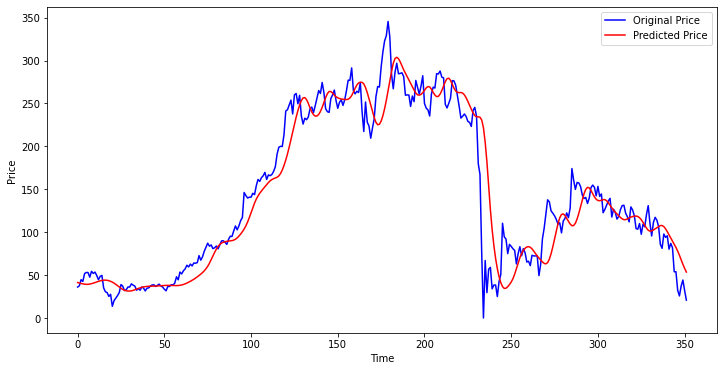

In [25]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b', label = 'Original Price')
plt.plot(Y_predicted, 'r', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [26]:
#get the root mean square error(RMSE)
rmse = np.sqrt(np.mean(Y_predicted - y_test)**2)
rmse

1.8246031819241795

In [27]:
# Mean absolute error
mae = mean_absolute_error(y_test, Y_predicted)
print("Test MAE: %.6f" % mae)

Test MAE: 19.426983


### Add extra financial data

In [28]:
# pip install yfinance --upgrade --no-cache-dir

In [29]:
import json
import yfinance as yf

sec = yf.Ticker("BA")

In [30]:

print('Quarterly Earnings')
print(sec.quarterly_earnings)
print()

print('------Quarterly Financials')
print(sec.quarterly_financials)
print()
print('Quarterly Balance Sheet')
print(sec.quarterly_balance_sheet)
print()

print('Quarterly BalanceSheet')
print(sec.quarterly_balancesheet)
print()

print('Quarterly Cash Flow')
print(sec.quarterly_cashflow)
print()

Quarterly Earnings
             Revenue    Earnings
Quarter                         
2Q2021   16998000000   587000000
3Q2021   15278000000  -109000000
4Q2021   14793000000 -4143000000
1Q2022   13991000000 -1219000000

------Quarterly Financials
                                           2022-03-31     2021-12-31  \
Research Development                      633000000.0    678000000.0   
Effect Of Accounting Charges                     None           None   
Income Before Tax                       -1618000000.0  -4700000000.0   
Minority Interest                         130000000.0    153000000.0   
Net Income                              -1219000000.0  -4143000000.0   
Selling General Administrative            628000000.0    856000000.0   
Gross Profit                              534000000.0  -2025000000.0   
Ebit                                     -727000000.0  -3559000000.0   
Operating Income                         -727000000.0  -3559000000.0   
Other Operating Expenses           